In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import medmnist
from medmnist import INFO, Evaluator

In [3]:
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[.6], std=[.5])
])

# Загружаем данные
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

num_augmentations = 2
aug_data = []
for image, label in train_dataset:
  for _ in range(num_augmentations):
    aug_data.append((image,label))

final_train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_data])

# Разделяем обучающие данные на обучающий и проверочный датасет
train_data, val_data = train_test_split(final_train_dataset, test_size=0.2, random_state=42)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100.0%


Using downloaded and verified file: C:\Users\1\.medmnist\pathmnist.npz


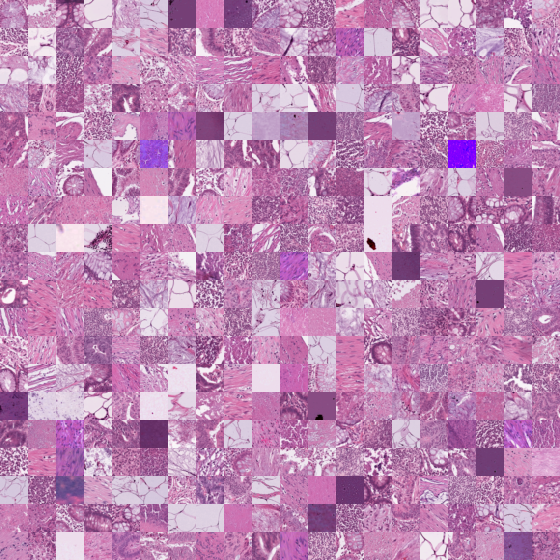

In [4]:
train_dataset.montage(length=20)

In [5]:
# Напишите ответ какого ранга тензор, содержащий 1 пакет ваших данных и укажите размерности этого тензора
for batch in train_dataloader:
    images, labels = batch
    print(f"Ранг тензора:", images.ndim)
    print(f"Размерности тензора:", images.shape)
    break

Ранг тензора: 4
Размерности тензора: torch.Size([128, 3, 28, 28])


In [6]:
# Код для получения доступных устройств для работы нейросети
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Используется {device}")

Используется cpu


In [7]:
# Реализация NeuralNetwork для нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # Преобразуем данные в одномерный тензор
        self.fc = nn.Sequential( #контейнер
            nn.Linear(3*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        ).to(device)

    def forward(self, x): #алгоритм передачи данных в нейронной сети
        x = self.flatten(x)
        return self.fc(x)


In [8]:
model = NeuralNetwork().to(device) # создаем модель
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=2352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):  # тренировка нейросети
    size = len(dataloader.dataset)
    total_loss, correct = 0, 0

    # Переключим модель в режим обучения
    model.to(device)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Вычислим предсказание, потери и метрики точности
        pred = model(X.to(device))
        y = y.squeeze().long()
        loss = loss_fn(pred, y.to(device))

        # Сохраним значение потерь и точности для построения графика
        total_loss += loss.item()
        correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

        # Обратное распространение ошибки
        optimizer.zero_grad() #зануляем градиент
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # Вычислим среднее значение потерь и точность для эпохи
    avg_loss = total_loss / size
    accuracy = correct / size

    return avg_loss, accuracy

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # Переключим модель в режим оценки
    model.to(device)
    model.eval()

    # Оценка модели с помощью torch.no_grad() гарантирует, что в тестовом режиме градиенты не будут вычисляться.
    # Также позволяет сократить количество ненужных вычислений градиентов и уменьшить расход памяти для тензоров
    with torch.no_grad():
        # Расчет предсказаний, потерь и метрики точности
        for X, y in dataloader:
            pred = model(X.to(device))
            y = y.squeeze().long()
            loss = loss_fn(pred, y.to(device))

            # Сохраним значение потерь и точности для построения графика
            test_loss += loss.item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    # Вычислим среднее значение потерь и точность для эпохи
    avg_loss = test_loss / size
    accuracy = correct / size

    return avg_loss, accuracy

Epoch 1
----------


loss: 2.302831  [  128/215990]
loss: 1.400894  [12928/215990]
loss: 1.137297  [25728/215990]
loss: 1.112207  [38528/215990]
loss: 1.261169  [51328/215990]
loss: 1.253306  [64128/215990]
loss: 1.181133  [76928/215990]
loss: 1.226650  [89728/215990]
loss: 1.134951  [102528/215990]
loss: 1.200490  [115328/215990]
loss: 0.972225  [128128/215990]
loss: 1.061802  [140928/215990]
loss: 0.965859  [153728/215990]
loss: 0.998140  [166528/215990]
loss: 1.117683  [179328/215990]
loss: 0.958543  [192128/215990]
loss: 1.106584  [204928/215990]
Test Error:
Accuracy: 62.8%, Avg loss: 0.007844 

Epoch 2
----------
loss: 0.856088  [  128/215990]
loss: 0.943258  [12928/215990]
loss: 1.050984  [25728/215990]
loss: 0.922345  [38528/215990]
loss: 0.887840  [51328/215990]
loss: 0.800805  [64128/215990]
loss: 0.957595  [76928/215990]
loss: 1.009474  [89728/215990]
loss: 1.015140  [102528/215990]
loss: 0.886894  [115328/215990]
loss: 0.902560  [128128/215990]
loss: 0.747418  [140928/215990]
loss: 0.899800  [15

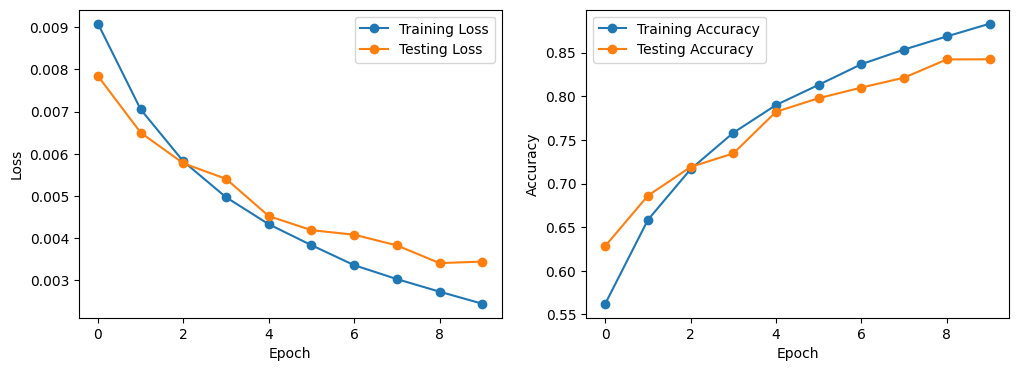

In [10]:
# Скорость обновления параметров модели в каждой эпохе
learning_rate = 0.001
# Количество итераций по набору данных
epochs = 10
# Функция потерь
loss_fn = nn.CrossEntropyLoss()
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Списки для хранения значений потерь и точности для построения графика
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n" + "-"*10)
    train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_loss, test_accuracy = test_loop(val_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Error:\nAccuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Постройм графики потерь и точности на обучающей и валидационной выборках.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(test_losses, label='Testing Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [11]:
# Задание: подберите гиперпараметры сети используя валидационную выборку.
# Попробуйте разные варианты архитектуры (глубина, ширина), количество эпох, скорость обучения.
# Возможно нормализация данных поможет повысить точность.
# Из не менее 6 вариантов модели выбирите лучшую и сохраните в best_net
class NeuralNetwork(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        hidden_layers = architecture['hidden_layers']

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*28*28, hidden_layers[0]).to(device)
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1]).to(device)
        self.fc3 = nn.Linear(hidden_layers[1], 10).to(device)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

best_accuracy = 0.0
best_net = None

# Define hyperparameters and architectures to search over
learning_rates = [0.001, 0.01]
epochs = [5, 10, 15]
model_architectures = [
    {'hidden_layers': [128, 64], 'activation': 'relu'},
    {'hidden_layers': [256, 128], 'activation': 'relu'},
    {'hidden_layers': [512, 256], 'activation': 'relu'},
]

for lr in learning_rates:
    for num_epochs in epochs:
        for architecture in model_architectures:
            model = NeuralNetwork(architecture)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()

            for epoch in range(num_epochs):
                train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
                # Optionally, you can perform validation here as well and track validation accuracy

            # Calculate accuracy on the validation set
            _, validation_accuracy = test_loop(val_dataloader, model, loss_fn)

            # Check if this model has the best validation accuracy so far
            if validation_accuracy > best_accuracy:
                best_hps = [lr, num_epochs]
                best_accuracy = validation_accuracy
                best_net = model

print(best_hps)

loss: 2.300094  [  128/215990]
loss: 1.581915  [12928/215990]
loss: 1.499260  [25728/215990]
loss: 1.357757  [38528/215990]
loss: 1.422716  [51328/215990]
loss: 1.267320  [64128/215990]
loss: 1.201800  [76928/215990]
loss: 1.394376  [89728/215990]
loss: 1.202465  [102528/215990]
loss: 1.224792  [115328/215990]
loss: 1.066257  [128128/215990]
loss: 1.079014  [140928/215990]
loss: 1.060074  [153728/215990]
loss: 1.118038  [166528/215990]
loss: 1.164157  [179328/215990]
loss: 0.978185  [192128/215990]
loss: 1.063933  [204928/215990]
loss: 0.989290  [  128/215990]
loss: 0.983441  [12928/215990]
loss: 1.043365  [25728/215990]
loss: 0.991149  [38528/215990]
loss: 0.933358  [51328/215990]
loss: 1.072878  [64128/215990]
loss: 0.924648  [76928/215990]
loss: 1.045146  [89728/215990]
loss: 0.992554  [102528/215990]
loss: 1.039521  [115328/215990]
loss: 0.885151  [128128/215990]
loss: 0.954365  [140928/215990]
loss: 0.820166  [153728/215990]
loss: 0.942141  [166528/215990]
loss: 0.801676  [179328/

In [12]:
best_accuracy

0.8730323345309086

In [13]:
from torchinfo import summary
summary(best_net, input_size=((128, 3, 28, 28)))


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [128, 10]                 --
├─Flatten: 1-1                           [128, 2352]               --
├─Linear: 1-2                            [128, 512]                1,204,736
├─ReLU: 1-3                              [128, 512]                --
├─Linear: 1-4                            [128, 256]                131,328
├─ReLU: 1-5                              [128, 256]                --
├─Linear: 1-6                            [128, 10]                 2,570
Total params: 1,338,634
Trainable params: 1,338,634
Non-trainable params: 0
Total mult-adds (M): 171.35
Input size (MB): 1.20
Forward/backward pass size (MB): 0.80
Params size (MB): 5.35
Estimated Total Size (MB): 7.36

In [14]:
# Запуск на тестовой выборке
_, test_acc = test_loop(test_dataloader, best_net, loss_fn)
print('Точность на тестовой выборке: ', test_acc*100, '%')


Точность на тестовой выборке:  62.68802228412256 %


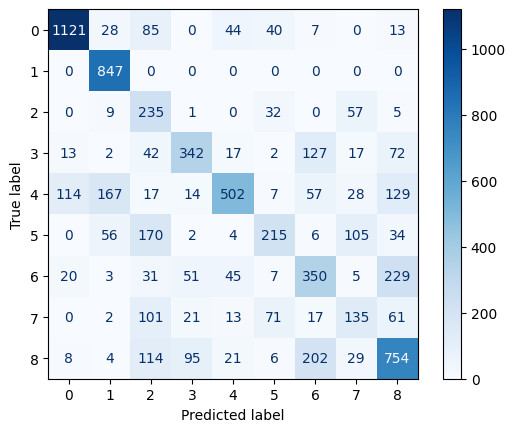

In [15]:
# Постройте матрицу смешения (confusion matrix)
# Опишите гипотезу о возможных проблемах вашей модели
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


best_net.eval()


true_labels = []
predicted_labels = []


with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        outputs = best_net(inputs.to(device))
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.cpu().numpy())


confusion = confusion_matrix(true_labels, predicted_labels)

# Матрица смешения (confusion_matrix)
disp = ConfusionMatrixDisplay(confusion, display_labels=range(9))  # Assuming 10 classes in MNIST
disp.plot(cmap=plt.cm.Blues, values_format='d')
